- Reference
  - Blog: https://work-in-progress.hatenablog.com/entry/2019/04/06/113629
  - Source: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [1]:
import os

In [2]:
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/saved_models', exist_ok=True)

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [7]:
class DCGAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        self.img_save_dir = 'data/images'
        self.model_save_dir = 'data/saved_models'
        self.discriminator_name = 'discriminator_model'
        self.generator_name = 'generator_model'
        self.combined_name = 'combined_model'

        self.discriminator = None
        self.generator = None
        self.combined = None

        # NHWC
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.latent_dim = 100

    def init(self, loading=False):
        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        if loading:
            self.load_model_weight(self.discriminator_name)

        self.generator = self.build_generator()
        if loading:
            self.load_model_weight(self.generator_name)

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.summary()
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        if loading:
            self.load_model_weight(self.combined_name)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())

        model.add(Conv2D(128, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(Conv2D(self.channels, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(Activation('tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', data_format='channels_last'))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=-1, save_interval=-1):
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
        #print(X_train.shape)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        #print(X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        print(datetime.datetime.now().isoformat(), 'Epoch Start')

        for epoch in range(epochs):
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            if sample_interval > 0 and epoch % sample_interval == 0:
                print(datetime.datetime.now().isoformat(), '%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

            if save_interval > 0 and epoch != 0 and epoch % save_interval == 0:
                self.save_model_weights_all()
                
        print(datetime.datetime.now().isoformat(), 'Epoch End')

    def generate_image(self):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        return self.generator.predict(noise)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        file_name = 'mnist_{}.png'.format(epoch)
        file_path = os.path.join(self.img_save_dir, file_name)
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()
 
    def save_model_weights_all(self):
        self.save_model_weights(self.discriminator, self.discriminator_name)
        self.save_model_weights(self.generator, self.generator_name)
        self.save_model_weights(self.combined, self.combined_name)

    def save_model_weights(self, model, model_name):
        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))
        model.save_weights(weights_path)

        print('Weights saved.', model_name)

    def load_model_weight(self, model_name):
        model = None

        if model_name == self.discriminator_name:
            model = self.discriminator
        elif model_name == self.generator_name:
            model = self.generator
        elif model_name == self.combined_name:
            model = self.combined

        if not model:
            print('Model is not initialized.', model_name)
            return

        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))

        if not os.path.exists(weights_path):
            print('Not found h5 file.', model_name)
            return

        model.load_weights(weights_path)

        print('Weights loaded.', model_name)

In [8]:
dcgan = DCGAN()
dcgan.init()
#dcgan.init(loading=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

In [9]:
#dcgan.train(epochs=500, batch_size=32, sample_interval=50, save_interval=50)
#dcgan.train(epochs=500, batch_size=32, sample_interval=50)
#dcgan.save_model_weights_all()

dcgan.train(epochs=10, batch_size=32, sample_interval=3, save_interval=3)

2020-07-20T19:44:14.712919 Epoch Start
2020-07-20T19:44:16.649003 0 [D loss: 0.941083, acc.: 39.06%] [G loss: 0.680272]
2020-07-20T19:44:18.062313 3 [D loss: 0.153694, acc.: 98.44%] [G loss: 0.808212]
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_model
2020-07-20T19:44:19.373264 6 [D loss: 0.447688, acc.: 75.00%] [G loss: 1.488739]
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_model
2020-07-20T19:44:20.749591 9 [D loss: 0.534962, acc.: 68.75%] [G loss: 1.376726]
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_model
2020-07-20T19:44:21.256046 Epoch End


In [10]:
dcgan.train(epochs=1000, batch_size=32, sample_interval=50)

dcgan.save_model_weights_all()

2020-07-20T19:45:45.032067 Epoch Start
2020-07-20T19:45:45.307815 0 [D loss: 0.346159, acc.: 84.38%] [G loss: 1.136025]
2020-07-20T19:45:59.046472 50 [D loss: 0.710448, acc.: 51.56%] [G loss: 1.317258]
2020-07-20T19:46:13.651003 100 [D loss: 0.809039, acc.: 50.00%] [G loss: 1.233445]
2020-07-20T19:46:28.227528 150 [D loss: 0.865840, acc.: 50.00%] [G loss: 1.073700]
2020-07-20T19:46:43.305090 200 [D loss: 0.779642, acc.: 56.25%] [G loss: 1.106775]
2020-07-20T19:46:58.256123 250 [D loss: 0.663817, acc.: 60.94%] [G loss: 0.982314]
2020-07-20T19:47:13.722206 300 [D loss: 0.556967, acc.: 68.75%] [G loss: 1.093210]
2020-07-20T19:47:28.565918 350 [D loss: 0.191812, acc.: 98.44%] [G loss: 0.925282]
2020-07-20T19:47:43.429664 400 [D loss: 0.328613, acc.: 87.50%] [G loss: 0.949822]
2020-07-20T19:47:58.416251 450 [D loss: 0.054485, acc.: 100.00%] [G loss: 0.924554]
2020-07-20T19:48:13.242152 500 [D loss: 0.059075, acc.: 100.00%] [G loss: 0.538307]
2020-07-20T19:48:27.841032 550 [D loss: 0.032597,

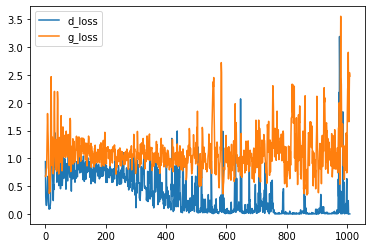

In [11]:
dcgan.plot_hisotry(['d_loss', 'g_loss'])

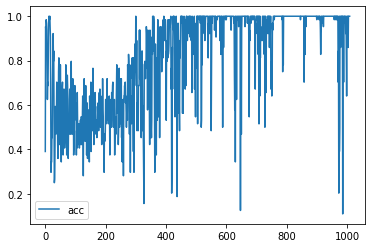

In [12]:
dcgan.plot_hisotry(['acc'])

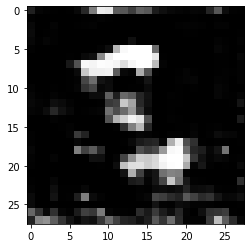

In [14]:
plt.imshow((dcgan.generate_image())[0], cmap='gray')